In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from qiskit import IBMQ
import pickle
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed


In [3]:
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [4]:
xlr = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_xlr.txt", sep = "\t")
nsd = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_nsd.txt", sep = "\t")
sd = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_sd.txt", sep = "\t")

In [13]:
all_columns = ['MeanCvg', 'NRC_poolNorm', 'Class']
features = all_columns[:-1]
labels = all_columns[-1]

X_train, X_test, y_train, y_test = train_test_split(xlr[features], xlr[labels], train_size=100, random_state=42,stratify=xlr[labels])

In [26]:
#set backend
IBMQ.save_account('cf5d46089379e94dc7ae62948bdccab7fc3703d3fc03d4fc73957dccd4e688aed0c7cbf3a65ba18b1f675632ef4e6b28e40d8223dd7356213b069c36194b5078',overwrite=True)
provider = IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q','open','main')
#provider = IBMQ.get_provider('partner-cnr','iit','qml-for-genomics')

num_qubits = 2

from qiskit.providers.ibmq import least_busy
possible_devices = provider.backends(filters=lambda x: 
        x.configuration().n_qubits >= num_qubits
                                       and 
        x.configuration().simulator == False)
backend = least_busy(possible_devices)
print(backend)




ibmqfactory.load_account:WARNING:2022-05-26 16:46:06,660: Credentials are already in use. The existing account in the session will be replaced.


ibmq_belem


In [15]:
scaler = MinMaxScaler(feature_range = (0, 2*np.pi))
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
nsd_scaled = scaler.transform(nsd[features])
sd_scaled = scaler.transform(sd[features])

y_nsd = nsd[labels]
y_sd = sd[labels]

In [16]:
xlr_eval, _, y_xlr_eval, _ = train_test_split(X_test_scaled, y_test, train_size= 100, random_state=42,stratify=y_test)
nsd_eval, _, y_nsd_eval, _ = train_test_split(nsd_scaled, y_nsd, train_size= 100, random_state=42,stratify=y_nsd)
sd_eval, _, y_sd_eval, _ = train_test_split(sd_scaled, y_sd, train_size= 100, random_state=42,stratify=y_sd)

## Caso Classico

In [7]:
normal_svc = SVC(kernel = "rbf", C= 20)
time_classic=datetime.now()
normal_svc.fit(X_train_scaled, y_train)
print('tempo esecuzione:', datetime.now()-time_classic)


tempo esecuzione: 0:00:00.639788


In [12]:
np.shape(xlr_eval)

(5000, 2)

In [21]:
normal_score_xlr = normal_svc.score(xlr_eval, y_xlr_eval)
normal_score_nsd = normal_svc.score(nsd_eval, y_nsd_eval)
normal_score_sd = normal_svc.score(sd_eval, y_sd_eval)
print(f"RBF kernel classification test score sd: {normal_score_sd}")
print(f"RBF kernel classification test score NSD: {normal_score_nsd}")
print(f"RBF kernel classification test score SD: {normal_score_sd}")

RBF kernel classification test score sd: 0.7838
RBF kernel classification test score NSD: 0.8204
RBF kernel classification test score SD: 0.7838


# Caso Quantum


In [29]:
#define ft map
#define kernel and quantumInstance
num_qubits = 2
shots= 1024
feature_map = ZZFeatureMap(feature_dimension=num_qubits,entanglement='linear')

quantum_instance = QuantumInstance(backend,shots=shots,skip_qobj_validation=False)

adhoc_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)



In [30]:
print(backend)

ibmq_belem


In [31]:
#evaluate kernel
qkernel_train=adhoc_kernel.evaluate(X_train_scaled)
qkernel_test=adhoc_kernel.evaluate(xlr_eval,X_train_scaled)

Job limit reached, waiting for job 628f93257feed7739407ab22 to finish before submitting the next one.
Job limit reached, waiting for job 628f932addb96f681374a5fb to finish before submitting the next one.
Job limit reached, waiting for job 628f932d8de2736d96f65f4f to finish before submitting the next one.
Job limit reached, waiting for job 628f932e055f2dfe7cd32dd1 to finish before submitting the next one.
Job limit reached, waiting for job 628f955d9a91dd59b3839250 to finish before submitting the next one.
Job limit reached, waiting for job 628f955fdbbc0f30f263f7d5 to finish before submitting the next one.
Job limit reached, waiting for job 628f9561055f2d6366d32de4 to finish before submitting the next one.
Job limit reached, waiting for job 628f9563ddb96fe1f874a605 to finish before submitting the next one.


In [20]:
# save the model to disk
filename = '/CTGlab/home/valeria/Quantum/Sim_QSVM/ZZ_ftmap_100pt/qsvc_train.pkl'
pickle.dump(qkernel_train, open(filename, 'wb'))
# save the model to disk
filename = '/CTGlab/home/valeria/Quantum/Sim_QSVM/ZZ_ftmap_100pt/qsvc_test.pkl'
pickle.dump(qkernel_test, open(filename, 'wb'))
 

In [23]:
svc_quantum=SVC(kernel="precomputed",C=100)
time_quntum=datetime.now()
svc_quantum.fit(qkernel_train, y_train)
print('tempo esecuzione quantum:', datetime.now()-time_quntum)

tempo esecuzione quantum: 0:00:00.006886


In [10]:
adhoc_score_xlr = adhoc_svc.score(xlr_eval, y_xlr_eval)
time_xlr=datetime.now()
print(f"Callable kernel classification test score XLR: {adhoc_score_xlr}")
print('tempo di esecuzione valutazione xlr:',datetime.now()-time_xlr)

NameError: name 'adhoc_svc' is not defined

In [16]:
kernel = adhoc_kernel.evaluate(x_vec = X_train_scaled)

In [17]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=X_train_scaled)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=xlr_eval, y_vec=y_xlr_eval)


KeyboardInterrupt: 

# Immagini


/CTGlab/home/valeria/miniconda3/envs/daism/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


False

In [18]:
matrix_train = sklearn.metrics.pairwise.rbf_kernel(X_train_scaled,xlr_eval)
matrix_test = sklearn.metrics.pairwise.rbf_kernel(xlr_eval)


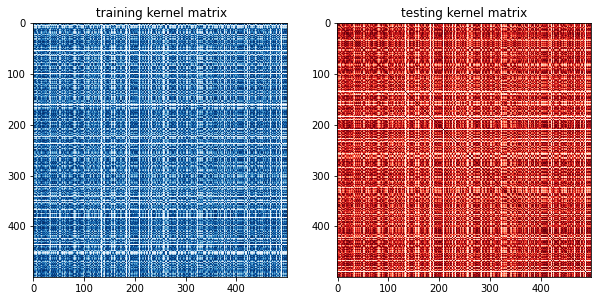

In [19]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
     np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues")
axs[0].set_title(" training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("testing kernel matrix")
plt.savefig('./rbf_kernel.png')
# 

In [ ]:
normal_svc.pred

In [11]:
def make_meshgrid(x, y, h=.01):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    plt.colorbar(out)
    return out





In [12]:
xlr_df=pd.DataFrame(xlr_eval,columns=['NRC_poolNorm','meanCvg'])
xlr_df['label']=y_xlr_eval.to_list()
xlr_df.head()

,NRC_poolNorm,meanCvg,label
0,0.533346,5.093846,-1
1,1.528913,4.860089,0
2,1.020306,5.322404,0
3,1.648606,4.943756,-1
4,0.973192,5.648286,1


In [13]:
xlr_df.sort_values(by='label',ascending=False,inplace=True)


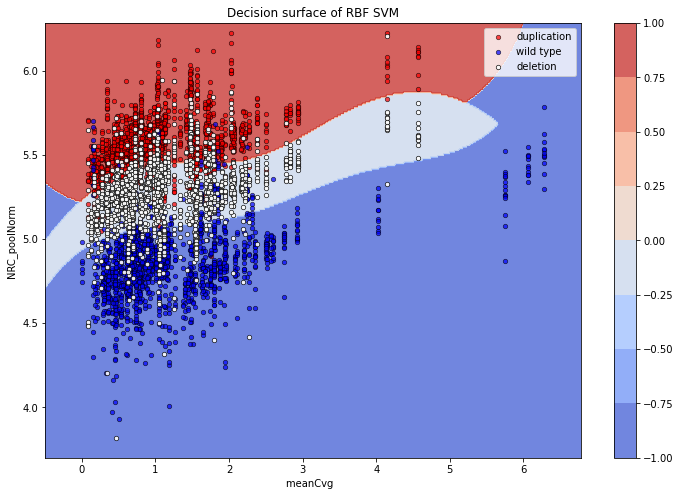

In [53]:

#plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(12,8))


# title for the plots
title = ('Decision surface of RBF SVM')
# Set-up grid for plotting.
X0, X1 = xlr_eval[:, 0], xlr_eval[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax,normal_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(xlr_df[xlr_df['label']==1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==1]['meanCvg'], c='r', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='duplication')
ax.scatter(xlr_df[xlr_df['label']==-1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==-1]['meanCvg'], c='b', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='wild type')
ax.scatter(xlr_df[xlr_df['label']==0.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==0]['meanCvg'], c='w', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.9,label='deletion')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')

#ax.set_xticks(())
#ax.set_yticks(())
#plt.xlim()
plt.ylim(3.7,2*np.pi+0.0)

ax.set_title(title)
ax.legend()
plt.show()


In [22]:
sd_df=pd.DataFrame(sd_eval,columns=['NRC_poolNorm','meanCvg'])
sd_df['label']=y_sd_eval.to_list()
sd_df.head()

,NRC_poolNorm,meanCvg,label
0,1.931651,4.879465,-1
1,1.608223,4.972066,-1
2,0.799655,5.390314,0
3,0.641579,5.410552,1
4,1.745925,5.703475,1


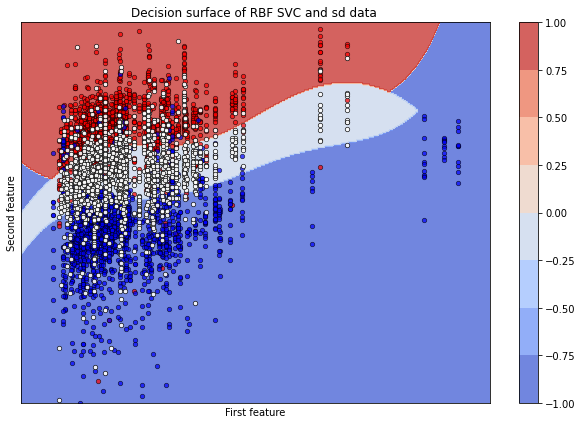

In [23]:
fig, ax = plt.subplots(figsize=(10.5,7))
# title for the plots
title = ('Decision surface of RBF SVC and sd data ')
# Set-up grid for plotting.
X0, X1 = sd_eval[:, 0], sd_eval[:, 1]
xx, yy = make_meshgrid(X0, X1,h=0.01)

plot_contours(ax,normal_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(sd_df[sd_df['label']==1.0]['NRC_poolNorm'],sd_df[sd_df['label']==1]['meanCvg'], c='r', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='duplication')
ax.scatter(sd_df[sd_df['label']==-1.0]['NRC_poolNorm'],sd_df[sd_df['label']==-1]['meanCvg'], c='b', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='wild type')
ax.scatter(sd_df[sd_df['label']==0.0]['NRC_poolNorm'],sd_df[sd_df['label']==0]['meanCvg'], c='w', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.9,label='deletion')
ax.set_ylabel('Second feature')
ax.set_xlabel('First feature')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend
plt.ylim(3.7,2*np.pi+0.0)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


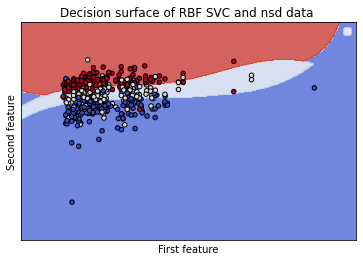

In [15]:
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of RBF SVC and nsd data ')
# Set-up grid for plotting.
X0, X1 = sd_eval[:, 0], sd_eval[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax,normal_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_sd_eval, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Second feature')
ax.set_xlabel('First feature')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
